In [2]:
import pandas as pd
import numpy as np
import elapid
from elapid import MaxentModel
import xarray as xr
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score

In [3]:
X_train = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/X_train.csv")
X_test = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/X_test.csv")
y_train = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/y_train.csv")
y_test = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/y_test.csv")

In [10]:
combined_df_nans = pd.read_parquet("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_1/total_df_with_nans_and_labels.parquet")


In [11]:
#Set up and run GridSearchCV for MaxEnt

model = elapid.MaxentModel()
param_grid = {
    'beta_multiplier': [0.5, 1.0, 2.0, 3.0, 4.0],
    'beta_hinge': [0.5, 1.0, 1.5, 2.0],
    'beta_threshold': [0.5, 1.0, 1.5, 2.0]
}

#Perform Grid Search CV
cv_model = GridSearchCV(
    model, param_grid, 
    scoring={
        'ROC': make_scorer(roc_auc_score, needs_proba=True)
    }, 
    refit='ROC', 
    cv=10,
    return_train_score=True
)
cv_model.fit(X_train, y_train)

/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/cluster/home

GridSearchCV(cv=10, estimator=MaxentModel(),
             param_grid={'beta_hinge': [0.5, 1.0, 1.5, 2.0],
                         'beta_multiplier': [0.5, 1.0, 2.0, 3.0, 4.0],
                         'beta_threshold': [0.5, 1.0, 1.5, 2.0]},
             refit='ROC', return_train_score=True,
             scoring={'ROC': make_scorer(roc_auc_score, response_method='predict_proba')})

In [12]:
#Evaluate the test performance
best_model = cv_model.best_estimator_

y_test_pred = best_model.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_test_pred)

print(f"Test AUC: {auc_score:.3f}")
print("Best regularization parameters found:", cv_model.best_params_)

Test AUC: 0.911
Best regularization parameters found: {'beta_hinge': 0.5, 'beta_multiplier': 0.5, 'beta_threshold': 0.5}


In [16]:
#Predict across full model area 
x_coords = combined_df_nans['x']
y_coords = combined_df_nans['y']
features_only = combined_df_nans.drop(columns=['x', 'y', 'labels'], errors='ignore')
X_grid_clean = features_only.dropna()
valid_idx = X_grid_clean.index

chunk_size = 2000
num_chunks = int(np.ceil(len(X_grid_clean) / chunk_size))
predicted_probabilities_list = []

for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, len(X_grid_clean))
    chunk = X_grid_clean.iloc[start:end]
    probs = best_model.predict_proba(chunk)[:, 1]
    predicted_probabilities_list.append(probs)

predicted_probs = np.concatenate(predicted_probabilities_list)


In [17]:
all_probabilities = np.full((len(combined_df_nans),), np.nan)

all_probabilities[valid_idx] = predicted_probs

num_x = len(np.unique(x_coords))
num_y = len(np.unique(y_coords))

In [19]:
sorted_idx = np.lexsort((x_coords, y_coords))  
all_probs_sorted = all_probabilities[sorted_idx]

In [20]:
predicted_grid = all_probs_sorted.reshape((num_y, num_x))

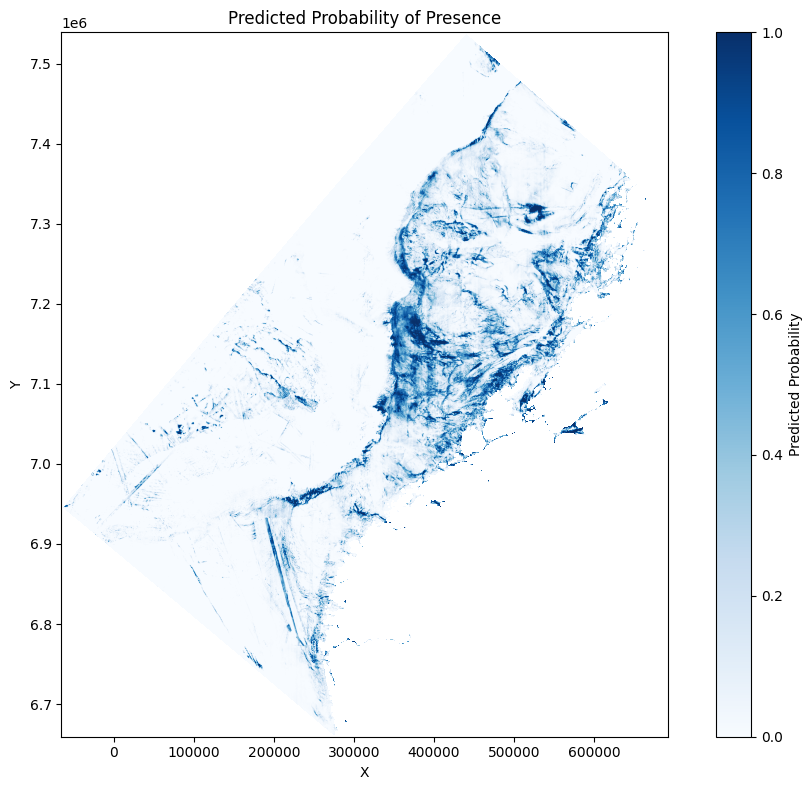

In [24]:
import matplotlib.pyplot as plt

x_sorted = np.sort(np.unique(x_coords))
y_sorted = np.sort(np.unique(y_coords))

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(predicted_grid, cmap='Blues', origin='lower', extent=[x_sorted[0], x_sorted[-1], y_sorted[0], y_sorted[-1]])
plt.colorbar(label='Predicted Probability')
plt.title('Predicted Probability of Presence')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

In [ ]:
coral = xr.

In [25]:
np.save("/cluster/home/maikents/sinmod_features_masters/predicted_probabilities_pipeline1.npy", predicted_grid)


In [26]:
coral_filepath_emod = '/cluster/home/maikents/features_midnor_2019/coral_data/midnor_coral_data_emod_grid.parquet'
coral_data_emod = pd.read_parquet(coral_filepath_emod)

In [27]:
coral_x = coral_data_emod['x']
coral_y = coral_data_emod['y']

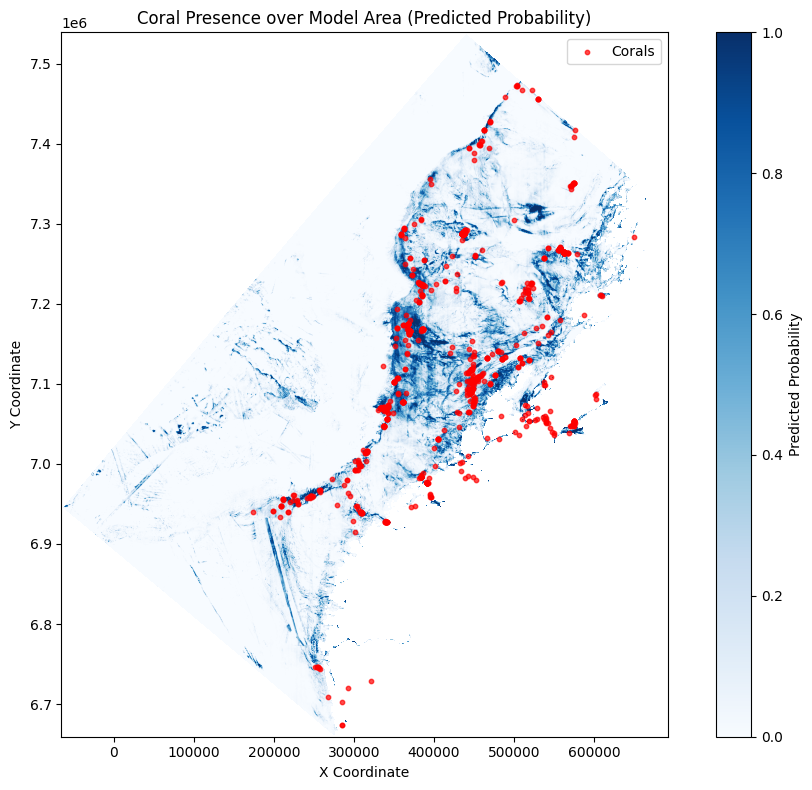

In [38]:
import numpy as np
import matplotlib.pyplot as plt


# Assuming prob_grid is already defined with the predicted probabilities

# Scatter plot for coral data
coral_x = coral_data_emod['x']  # Coral x-coordinates
coral_y = coral_data_emod['y']  # Coral y-coordinates

# Determine the range of the predicted probabilities for proper color scaling
vmin = np.nanmin(predicted_grid)  # Minimum value in the grid (e.g., 0.0)
vmax = np.nanmax(predicted_grid)  # Maximum value in the grid (e.g., 1.0)

# Create a figure
plt.figure(figsize=(10, 8))

# Plot the predicted probabilities (model grid)
cax = plt.imshow(predicted_grid, cmap='Blues', origin='lower', 
                 extent=[x_sorted[0], x_sorted[-1], y_sorted[0], y_sorted[-1]], 
                 vmin=vmin, vmax=vmax)

# Scatter coral points on top (red dots)
plt.scatter(coral_x, coral_y, color='red', label='Corals', s=10, alpha=0.7)

# Create a color bar and link it to the imshow plot
cbar = plt.colorbar(cax, label='Predicted Probability')

# Add title, axis labels
plt.title('Coral Presence over Model Area (Predicted Probability)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Display the plot
plt.legend()
plt.tight_layout()
plt.show()

